# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime
import time
from collections import deque
import matplotlib.pyplot as plt

In [2]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [3]:
import networkit as nk
import networkx as nx

# Setting

In [4]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "Real", "youtube")
    data_amazon = os.path.join(_data, "Real", "amazon")
    data_dblp = os.path.join(_data, "Real", "dblp")
    data_comlj = os.path.join(_data, "Real", "com-lj")
    
    data_train = os.path.join(_data, "train")
    data_valid = os.path.join(_data, "valid")
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", "2021-03-23 00-57")
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 500
    
    nodes_cnt = 3000

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [5]:
setting = Setting()

In [6]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-23 00-57'

# Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

## Functions

### Load all data

In [7]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)
            
            # get filename without extension
            f = os.path.splitext(f)[0]
            p = os.path.join(path, "{}_score.txt".format(f))
            between.append(p)
    
    return edge_index, between

### Split Data

In [8]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)

### Cvt 2 Data

In [9]:
def to_data(x, y=None, x_sep=None, y_sep=None, usecols=None):
    
    if x_sep is not None:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long, sep=x_sep)
    else:
        edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    if y is not None:
        ### between centrality
        bc = np.loadtxt(y, delimiter=y_sep, usecols=usecols)
        bc = np.reshape(bc, (-1, 1))
        bc = torch.from_numpy(bc)

        data = Data(x=vertice, edge_index=edge_index, y=bc)
        
    else:
        data = Data(x=vertice, edge_index=edge_index)
    
    return data

### Cvt 2 dataloader

In [10]:
def to_dataloader(x, y, batch, y_sep=None, usecols=None):
    
    data_list = []
    for x_, y_ in zip(x, y):
        data = to_data(x_, y_, y_sep=y_sep, usecols=usecols)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return loader

### Cvt nx.Graph 2 PyG.Data

In [11]:
def from_networkx(G, between_list=None):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    
    if between_list is not None:
        data['y'] = torch.from_numpy(
            np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

### Randomly generate nx.Graph

In [12]:
def generate_nx_graph(nodes_cnt):
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    return G, bc_gt

#### Generate 10,000 for train

In [ ]:
nodes_cnt = setting.nodes_cnt

In [ ]:
train_dir = os.path.join(setting._data, "train", str(nodes_cnt))
if os.path.exists(train_dir):
    pass
else:
    os.makedirs(train_dir)

In [ ]:
for i in range(10000):
    G, bc_gt = generate_nx_graph(nodes_cnt)
    edge_f = open(os.path.join(train_dir, "{}.txt".format(i)), "wb")
    nx.readwrite.edgelist.write_edgelist(G, edge_f, data=False)
    
    bc_gt = bc_gt.numpy()
    np.savetxt(os.path.join(train_dir, "{}_score.txt".format(i)), bc_gt, fmt="%.20f")

#### Generate 100 for validation

In [ ]:
valid_dir = os.path.join(setting._data, "valid", str(nodes_cnt))
if os.path.exists(valid_dir):
    pass
else:
    os.makedirs(valid_dir)

In [ ]:
for i in range(100):
    G, bc_gt = generate_nx_graph(nodes_cnt)
    edge_f = open(os.path.join(valid_dir, "{}.txt".format(i)), "wb")
    nx.readwrite.edgelist.write_edgelist(G, edge_f, data=False)
    
    bc_gt = bc_gt.numpy()
    np.savetxt(os.path.join(valid_dir, "{}_score.txt".format(i)), bc_gt, fmt="%.20f")

## Read data

### Load test data

In [14]:
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

In [15]:
train, train_bet = load_data(os.path.join(setting.data_train, str(setting.nodes_cnt)))

In [16]:
valid, valid_bet = load_data(os.path.join(setting.data_valid, str(setting.nodes_cnt)))

### Cvt to data/dataloader

In [17]:
train_loader = to_dataloader(train, train_bet, batch=16)
valid_loader = to_dataloader(valid, valid_bet, batch=16)

In [ ]:
for batch in train_loader:
    print(batch.y)

In [18]:
syn_loader = to_dataloader(synthetic, between, batch=1, usecols=1)

In [19]:
yt_loader = to_dataloader(yt, yt_score, batch=1, y_sep=":", usecols=1)

# Model

## Hyper params

In [20]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

setting.params_node2vec = dict(
    in_features = 128
)

## DrBC

In [21]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [22]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [23]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [24]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [25]:
import node2vec
from gensim.models import Word2Vec

INFO:gensim.summarization.textcleaner:'pattern' package not found; tag filters are not available for English


In [26]:
def learn_embeddings(walks, dim=128, window=10, workers=8, iters=1):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    walks = [list(map(str, walk)) for walk in walks]
    model = Word2Vec(walks, size=dim, window=window, min_count=0, sg=1, workers=workers, iter=iters)
    
    return model.wv



def gnx_to_emb(G, nodes_cnt):
    for edge in G.edges():
        G[edge[0]][edge[1]]['weight'] = 1

    G = node2vec.Graph(G, False, p=1, q=1)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(10, 80)

    embs = learn_embeddings(walks)
    embs_ = []
    for index in range(nodes_cnt):
        embs_.append(torch.from_numpy(np.array(embs.get_vector(str(index)), dtype=np.float)))
    embs_ = torch.stack(embs_)
    
    
    return embs_

In [27]:
class BC_node2vec(nn.Module):
    
    def __init__(self, in_features):
        super().__init__()

        self.mlp = nn.Linear(in_features=in_features, out_features=1).double()
        
    def forward(self, emb):
        
        return self.mlp(emb)

# Evaluation

## Top k %

In [28]:
def top_n_percentage(bc_gt, bc_pr, k):
    
    if not isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.from_numpy(bc_gt)
    bc_gt = bc_gt.to(setting.device)
    bc_gt = torch.reshape(bc_gt, (-1, ))
    
    if not isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.from_numpy(bc_pr)
    bc_pr = bc_pr.to(setting.device)
    bc_pr = torch.reshape(bc_pr, (-1, ))
    
    nodes = bc_gt.size()[0]
    k = int(nodes * k / 100)
    
    gt_value, gt_indice = torch.topk(bc_gt, k)
    pr_value, pr_indice = torch.topk(bc_pr, k)

    gt_indice = set(gt_indice.cpu().numpy())
    pr_indice = set(pr_indice.cpu().numpy())

    intersect = len(gt_indice & pr_indice)
    top = intersect/k
    
    return top

## Tau Kendal

In [29]:
from scipy import stats

def kendal_tau_distance(bc_gt, bc_pr):
    
    if isinstance(bc_gt, torch.Tensor):
        bc_gt = torch.reshape(bc_gt, (-1, ))
        bc_gt = bc_gt.cpu().detach().numpy()
        
    if isinstance(bc_pr, torch.Tensor):
        bc_pr = torch.reshape(bc_pr, (-1, ))
        bc_pr = bc_pr.cpu().detach().numpy()
    
    tau, p_value = stats.kendalltau(bc_gt, bc_pr)
    return tau

# Train

## Load model

In [30]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

In [31]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

model

use a new optimizer


DrBC(
  (encoder): Encoder(
    (w_0): Linear(in_features=3, out_features=128, bias=True)
    (relu): ReLU(inplace=True)
    (rnn): GRUCell(128, 128)
  )
  (decoder): Decoder(
    (w_4): Linear(in_features=128, out_features=64, bias=True)
    (w_5): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU(inplace=True)
  )
)

## DrBC

In [32]:
nodes_cnt = setting.nodes_cnt


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
#     G, bc_gt = generate_nx_graph(nodes_cnt)
    
#     # Convert networkx.Graph to Pyg Data
#     G = from_networkx(G)

    print("\nEpoch: {}".format(epoch+1))

    for batch in tqdm(train_loader):
    
        ### Start training
        optimizer.zero_grad()
        batch = batch.to(setting.device)

        bc_pr = model(batch)
    
        
        # compute batch loss
        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1
        
        batch_loss = torch.tensor(0, dtype=torch.float).to(setting.device)
        
        for b_ in range(b):
            
            indice, = np.where(b_index == b_)
            
            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()
            
            # random sample 5|V| nodes
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            
            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]
            
            y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)
        
            batch_loss += nn.BCELoss()(y_pr, y_gt)
        
        batch_loss = torch.div(batch_loss, b)
        batch_loss.backward()
        optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
        
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(train_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)
                

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(bce)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)
            
            
    
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(valid_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)
            

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)



        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            top_10 = top10
            
            torch.save(checkpoint, setting.weight_drbc)

  0%|          | 0/625 [00:00<?, ?it/s]


Epoch: 1


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931430470876371, top 1 = 0.9252033333332486, top 5 = 0.8923619999999606, top 10 = 0.8884063333333306, kendal = 0.7031800622429698


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931431365444941, top 1 = 0.9300000000000004, top 5 = 0.8897333333333337, top 10 = 0.8865999999999998, kendal = 0.7014029387573636

Epoch: 2


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931430259941023, top 1 = 0.9346066666665767, top 5 = 0.9163293333332733, top 10 = 0.9035876666666504, kendal = 0.7277819851506033


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430519238053, top 1 = 0.9400000000000006, top 5 = 0.9125999999999996, top 10 = 0.9008666666666663, kendal = 0.7248276536623321

Epoch: 3


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931430001700324, top 1 = 0.9412966666665792, top 5 = 0.9245593333332665, top 10 = 0.9100266666666519, kendal = 0.7248643106813397


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430472827473, top 1 = 0.9480000000000005, top 5 = 0.9199999999999993, top 10 = 0.9067333333333333, kendal = 0.7222278137156829

Epoch: 4


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931430002523542, top 1 = 0.9464666666665787, top 5 = 0.9304879999999277, top 10 = 0.9181146666666409, kendal = 0.7043190515505178


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931431039574337, top 1 = 0.9503333333333339, top 5 = 0.9248000000000001, top 10 = 0.916766666666667, kendal = 0.7018424452595308

Epoch: 5


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931430036903642, top 1 = 0.9510933333332449, top 5 = 0.9349346666665896, top 10 = 0.9237309999999712, kendal = 0.7229858790263419


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693142965954342, top 1 = 0.9550000000000005, top 5 = 0.9290666666666669, top 10 = 0.9210666666666666, kendal = 0.7199659219739913

Epoch: 6


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931430034388321, top 1 = 0.9550599999999171, top 5 = 0.9387746666665904, top 10 = 0.9293363333332986, kendal = 0.740263826786709


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429918680948, top 1 = 0.9593333333333338, top 5 = 0.9337333333333331, top 10 = 0.9265666666666671, kendal = 0.7373238990774699

Epoch: 7


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429862581031, top 1 = 0.9593166666665874, top 5 = 0.9418666666665843, top 10 = 0.9318543333332981, kendal = 0.7523280628209431


  0%|          | 1/625 [00:00<01:58,  5.28it/s]

Valid: loss = 0.69314307473621, top 1 = 0.9613333333333339, top 5 = 0.9360666666666666, top 10 = 0.9287333333333336, kendal = 0.7489716172057352

Epoch: 8


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429800575966, top 1 = 0.9622366666665885, top 5 = 0.9445806666665836, top 10 = 0.9348589999999666, kendal = 0.7628747025897517


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430177652282, top 1 = 0.9646666666666674, top 5 = 0.9394666666666665, top 10 = 0.9317666666666666, kendal = 0.7593820740246748

Epoch: 9


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429819310168, top 1 = 0.9643733333332589, top 5 = 0.9471066666665798, top 10 = 0.9373103333332979, kendal = 0.7743751934644898


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429385934905, top 1 = 0.9666666666666675, top 5 = 0.9422666666666665, top 10 = 0.9341000000000004, kendal = 0.7710095098366119

Epoch: 10


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429754551259, top 1 = 0.9661766666665932, top 5 = 0.949359999999912, top 10 = 0.9396336666666257, kendal = 0.7797196743803465


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429585392372, top 1 = 0.9690000000000006, top 5 = 0.9441999999999997, top 10 = 0.9360000000000004, kendal = 0.7765076803378907

Epoch: 11


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429793082938, top 1 = 0.9677066666665937, top 5 = 0.9509959999999102, top 10 = 0.9413363333332941, kendal = 0.78206363965766


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931428993694895, top 1 = 0.9706666666666672, top 5 = 0.9452666666666665, top 10 = 0.937, kendal = 0.7791460486828942

Epoch: 12


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429735711155, top 1 = 0.9690566666665964, top 5 = 0.9523619999999126, top 10 = 0.9426153333332908, kendal = 0.7849100127598128


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693142925479584, top 1 = 0.9710000000000006, top 5 = 0.9465999999999998, top 10 = 0.9383333333333337, kendal = 0.7820604201400465

Epoch: 13


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693142970373528, top 1 = 0.9702199999999329, top 5 = 0.9532786666665761, top 10 = 0.9441959999999584, kendal = 0.7888104623318873


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430228391043, top 1 = 0.9706666666666673, top 5 = 0.9476000000000002, top 10 = 0.9397000000000003, kendal = 0.7860747137934865

Epoch: 14


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429721889836, top 1 = 0.9712199999999344, top 5 = 0.9542559999999023, top 10 = 0.9453876666666238, kendal = 0.7934476901633857


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429579760366, top 1 = 0.9710000000000006, top 5 = 0.948133333333333, top 10 = 0.9415999999999998, kendal = 0.790722245192842

Epoch: 15


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429720807597, top 1 = 0.9720133333332699, top 5 = 0.9550726666665729, top 10 = 0.9466923333332881, kendal = 0.791824250661333


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429473449434, top 1 = 0.9706666666666673, top 5 = 0.9489333333333333, top 10 = 0.9424333333333331, kendal = 0.7892295253973546

Epoch: 16


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429745073542, top 1 = 0.9725699999999364, top 5 = 0.9560713333332371, top 10 = 0.9472013333332907, kendal = 0.7979124343670114


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429682139477, top 1 = 0.972333333333334, top 5 = 0.9508666666666667, top 10 = 0.9435000000000006, kendal = 0.7952217005668558

Epoch: 17


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429684518551, top 1 = 0.973056666666603, top 5 = 0.9563813333332415, top 10 = 0.9485633333332906, kendal = 0.8032177225741903


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429975147276, top 1 = 0.9746666666666672, top 5 = 0.9504000000000002, top 10 = 0.9446666666666667, kendal = 0.8004353673446704

Epoch: 18


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429651760231, top 1 = 0.9733033333332695, top 5 = 0.957135333333238, top 10 = 0.9492826666666231, kendal = 0.804732300144491


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430001682188, top 1 = 0.9740000000000006, top 5 = 0.9503333333333331, top 10 = 0.9459333333333332, kendal = 0.8019875025008338

Epoch: 19


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429656658235, top 1 = 0.9738599999999371, top 5 = 0.9583993333332376, top 10 = 0.9495073333332898, kendal = 0.8090823055685255


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931428701210683, top 1 = 0.9736666666666673, top 5 = 0.9528, top 10 = 0.9456666666666667, kendal = 0.8065411537179059

Epoch: 20


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693142969051601, top 1 = 0.9742766666666052, top 5 = 0.959184666666571, top 10 = 0.9500789999999532, kendal = 0.8132578960542415


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430041612959, top 1 = 0.9740000000000006, top 5 = 0.9537333333333338, top 10 = 0.9463666666666665, kendal = 0.810669378681783

Epoch: 21


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429729098524, top 1 = 0.9746533333332734, top 5 = 0.9600466666665716, top 10 = 0.9505943333332849, kendal = 0.8141511045015017


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430339640623, top 1 = 0.9740000000000006, top 5 = 0.955, top 10 = 0.945866666666666, kendal = 0.8114358475047239

Epoch: 22


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429704440427, top 1 = 0.9750733333332738, top 5 = 0.9608619999999001, top 10 = 0.9511739999999476, kendal = 0.8138742367900403


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430197576751, top 1 = 0.9740000000000006, top 5 = 0.955333333333333, top 10 = 0.9461999999999995, kendal = 0.8112468067133487

Epoch: 23


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429749279473, top 1 = 0.9754133333332733, top 5 = 0.9614186666665698, top 10 = 0.9518139999999504, kendal = 0.8202789918861814


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429914247116, top 1 = 0.9746666666666672, top 5 = 0.9563333333333336, top 10 = 0.9471999999999997, kendal = 0.8176205401800604

Epoch: 24


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429691885452, top 1 = 0.9758299999999408, top 5 = 0.9621279999999061, top 10 = 0.9521889999999498, kendal = 0.822095289985551


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430276854036, top 1 = 0.9746666666666672, top 5 = 0.956266666666667, top 10 = 0.9474666666666661, kendal = 0.8191779659886628

Epoch: 25


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429728191639, top 1 = 0.9762266666666086, top 5 = 0.9625779999999011, top 10 = 0.9527693333332843, kendal = 0.8236201658330563


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430473590161, top 1 = 0.9753333333333338, top 5 = 0.9570000000000003, top 10 = 0.9481666666666662, kendal = 0.8206662887629212

Epoch: 26


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429661412968, top 1 = 0.9765866666666109, top 5 = 0.9629859999999031, top 10 = 0.9531856666666174, kendal = 0.8242208270756942


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429574687336, top 1 = 0.9763333333333339, top 5 = 0.9574000000000003, top 10 = 0.948366666666667, kendal = 0.8213912059575418

Epoch: 27


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429660670154, top 1 = 0.9768799999999442, top 5 = 0.9633879999999021, top 10 = 0.9534119999999477, kendal = 0.824098471401574


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430032157074, top 1 = 0.9766666666666672, top 5 = 0.958466666666667, top 10 = 0.9481666666666668, kendal = 0.8211220273424473

Epoch: 28


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429695292567, top 1 = 0.9771899999999447, top 5 = 0.9636906666665651, top 10 = 0.9537853333332856, kendal = 0.8271623506057547


  0%|          | 1/625 [00:00<02:01,  5.15it/s]

Valid: loss = 0.6931430142541442, top 1 = 0.9766666666666672, top 5 = 0.958866666666667, top 10 = 0.9483666666666667, kendal = 0.8242094031343784

Epoch: 29


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429697234842, top 1 = 0.9773666666666122, top 5 = 0.9638939999998986, top 10 = 0.9539896666666172, kendal = 0.8275664349449818


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430447192674, top 1 = 0.9766666666666672, top 5 = 0.959266666666667, top 10 = 0.9489999999999996, kendal = 0.8245499744359229

Epoch: 30


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429645375536, top 1 = 0.9778166666666146, top 5 = 0.9640766666665684, top 10 = 0.9544649999999496, kendal = 0.8301398825386205


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430684649539, top 1 = 0.9770000000000006, top 5 = 0.9599333333333336, top 10 = 0.949233333333333, kendal = 0.8271670512393021

Epoch: 31


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429645676717, top 1 = 0.9778633333332822, top 5 = 0.9641079999999027, top 10 = 0.9547936666666176, kendal = 0.8291733507169016


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429343254984, top 1 = 0.9780000000000005, top 5 = 0.9605999999999999, top 10 = 0.9494999999999996, kendal = 0.826207975991997

Epoch: 32


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429728540353, top 1 = 0.9780999999999496, top 5 = 0.964458666666571, top 10 = 0.95561366666661, kendal = 0.8267715695454039


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430249424068, top 1 = 0.9783333333333338, top 5 = 0.9605999999999999, top 10 = 0.9502333333333337, kendal = 0.8240140846948986

Epoch: 33


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429728591287, top 1 = 0.9782599999999498, top 5 = 0.964411333333237, top 10 = 0.9556973333332782, kendal = 0.8310890935200601


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429824429497, top 1 = 0.9793333333333338, top 5 = 0.9601999999999999, top 10 = 0.9503666666666665, kendal = 0.8280841658330556

Epoch: 34


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429644471176, top 1 = 0.9784866666666161, top 5 = 0.964786666666573, top 10 = 0.9559166666666131, kendal = 0.8295882482160712


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430319714798, top 1 = 0.9796666666666672, top 5 = 0.9611999999999999, top 10 = 0.9503999999999998, kendal = 0.826528064910526

Epoch: 35


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429599920853, top 1 = 0.9786299999999488, top 5 = 0.9648659999999043, top 10 = 0.9561643333332771, kendal = 0.8331343943092142


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429618726156, top 1 = 0.9796666666666672, top 5 = 0.9616666666666663, top 10 = 0.9509666666666662, kendal = 0.8300188329443148

Epoch: 36


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429685380148, top 1 = 0.9787933333332824, top 5 = 0.9649399999998979, top 10 = 0.9566636666666117, kendal = 0.8331633176392146


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429865912351, top 1 = 0.9796666666666672, top 5 = 0.9614666666666664, top 10 = 0.9512999999999999, kendal = 0.8300317305768591

Epoch: 37


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.69314296424513, top 1 = 0.9788866666666171, top 5 = 0.9651173333332381, top 10 = 0.9570709999999419, kendal = 0.8343516340557986


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429745432247, top 1 = 0.9796666666666672, top 5 = 0.9617999999999998, top 10 = 0.9525666666666666, kendal = 0.8312101989552072

Epoch: 38


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429641520982, top 1 = 0.9790466666666165, top 5 = 0.9652339999999027, top 10 = 0.9574253333332728, kendal = 0.8331023587418022


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693143024721333, top 1 = 0.9790000000000006, top 5 = 0.9623999999999997, top 10 = 0.9527999999999998, kendal = 0.8301110414582641

Epoch: 39


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429712054737, top 1 = 0.9792499999999509, top 5 = 0.9652646666665682, top 10 = 0.9574816666666098, kendal = 0.8319366060686878


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430083917792, top 1 = 0.9796666666666672, top 5 = 0.9629333333333332, top 10 = 0.9530666666666666, kendal = 0.8288543114371457

Epoch: 40


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429742412714, top 1 = 0.9792166666666173, top 5 = 0.965537333333234, top 10 = 0.9578406666666075, kendal = 0.8367324443258892


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430184126897, top 1 = 0.9796666666666672, top 5 = 0.9627333333333331, top 10 = 0.9533666666666666, kendal = 0.8337751428253861

Epoch: 41


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429659735994, top 1 = 0.9794433333332845, top 5 = 0.965609333333234, top 10 = 0.9579139999999429, kendal = 0.8340101373791277


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429850447338, top 1 = 0.9803333333333338, top 5 = 0.9632666666666665, top 10 = 0.9533666666666666, kendal = 0.8310441124819381

Epoch: 42


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429699400865, top 1 = 0.9795199999999527, top 5 = 0.9656646666665665, top 10 = 0.9582606666666096, kendal = 0.8364924779370924


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429911216932, top 1 = 0.9806666666666672, top 5 = 0.9634666666666665, top 10 = 0.9538666666666668, kendal = 0.8336455707458041

Epoch: 43


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429653229454, top 1 = 0.9794999999999533, top 5 = 0.965811333333232, top 10 = 0.9584149999999423, kendal = 0.8386030893408911


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430252407018, top 1 = 0.9813333333333338, top 5 = 0.9637999999999998, top 10 = 0.9540000000000001, kendal = 0.8356904923863511

Epoch: 44


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429622580094, top 1 = 0.9795266666666194, top 5 = 0.9659666666665686, top 10 = 0.9587799999999401, kendal = 0.837369127353565


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429894758722, top 1 = 0.9823333333333337, top 5 = 0.9639999999999997, top 10 = 0.9543666666666666, kendal = 0.8344813471157048

Epoch: 45


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429715034658, top 1 = 0.97965666666662, top 5 = 0.9660719999998986, top 10 = 0.959118333333271, kendal = 0.8364088769589886


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931431350223491, top 1 = 0.9810000000000005, top 5 = 0.9640000000000001, top 10 = 0.9542999999999998, kendal = 0.8335960742469711

Epoch: 46


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429627240981, top 1 = 0.9797833333332866, top 5 = 0.9661733333332307, top 10 = 0.9590723333332735, kendal = 0.8398697821940626


  0%|          | 1/625 [00:00<01:57,  5.30it/s]

Valid: loss = 0.6931430280927394, top 1 = 0.9820000000000004, top 5 = 0.9644666666666666, top 10 = 0.9542666666666668, kendal = 0.8369122418583973

Epoch: 47


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693142954983154, top 1 = 0.9799666666666202, top 5 = 0.9661439999999011, top 10 = 0.9592953333332729, kendal = 0.8391967357119058


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693143032076983, top 1 = 0.9816666666666671, top 5 = 0.9643333333333333, top 10 = 0.9545666666666668, kendal = 0.836232548627321

Epoch: 48


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429678634161, top 1 = 0.9800599999999531, top 5 = 0.9663806666665677, top 10 = 0.9595163333332727, kendal = 0.8381055019673206


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430559863035, top 1 = 0.9820000000000004, top 5 = 0.9647333333333333, top 10 = 0.9549333333333335, kendal = 0.8353237123485602

Epoch: 49


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429666956871, top 1 = 0.9800733333332875, top 5 = 0.966513999999903, top 10 = 0.9597586666666035, kendal = 0.837658679915531


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429335972542, top 1 = 0.9820000000000004, top 5 = 0.9648666666666665, top 10 = 0.9550333333333334, kendal = 0.8348529643214404

Epoch: 50


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429739593312, top 1 = 0.9801899999999539, top 5 = 0.9665206666665679, top 10 = 0.9597793333332749, kendal = 0.8403722747582546


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693142987854433, top 1 = 0.9823333333333337, top 5 = 0.9650666666666665, top 10 = 0.9550000000000004, kendal = 0.8375668867400247

Epoch: 51


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429680170401, top 1 = 0.9801899999999547, top 5 = 0.9666973333332342, top 10 = 0.9599293333332732, kendal = 0.8385221998888537


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429948478224, top 1 = 0.9820000000000004, top 5 = 0.9653999999999998, top 10 = 0.9550666666666666, kendal = 0.8357609558741805

Epoch: 52


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429671293231, top 1 = 0.9802799999999546, top 5 = 0.9666959999999021, top 10 = 0.9598629999999428, kendal = 0.843522917594754


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429905830053, top 1 = 0.9816666666666671, top 5 = 0.9654666666666668, top 10 = 0.9551666666666669, kendal = 0.840592895409581

Epoch: 53


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429646039472, top 1 = 0.9803099999999544, top 5 = 0.9668433333332332, top 10 = 0.9601386666666076, kendal = 0.8417645350227886


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429224085016, top 1 = 0.9816666666666671, top 5 = 0.9654666666666668, top 10 = 0.9553333333333335, kendal = 0.8389497121262645

Epoch: 54


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429566660614, top 1 = 0.9803366666666212, top 5 = 0.9667633333332345, top 10 = 0.96004799999994, kendal = 0.8436365602311889


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429738640317, top 1 = 0.9823333333333337, top 5 = 0.9656, top 10 = 0.9551666666666666, kendal = 0.8407747693675667

Epoch: 55


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429707041606, top 1 = 0.9804099999999553, top 5 = 0.9668153333332346, top 10 = 0.9601933333332736, kendal = 0.8453313434700515


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430601775055, top 1 = 0.9823333333333337, top 5 = 0.9655999999999999, top 10 = 0.9553, kendal = 0.8424265199510947

Epoch: 56


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429662519744, top 1 = 0.9803433333332885, top 5 = 0.9669226666665676, top 10 = 0.9603646666666058, kendal = 0.8426721854395902


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693143048426411, top 1 = 0.9820000000000004, top 5 = 0.966, top 10 = 0.9556666666666667, kendal = 0.839809038568411

Epoch: 57


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429681984257, top 1 = 0.9804666666666211, top 5 = 0.9670493333332364, top 10 = 0.9604489999999442, kendal = 0.8454262406135366


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430992195693, top 1 = 0.9820000000000004, top 5 = 0.966, top 10 = 0.9560999999999997, kendal = 0.8425921218183838

Epoch: 58


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429682112753, top 1 = 0.9804899999999543, top 5 = 0.9671246666665724, top 10 = 0.9605723333332772, kendal = 0.8442568809603236


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693142896694063, top 1 = 0.9820000000000004, top 5 = 0.9662, top 10 = 0.9565333333333331, kendal = 0.8414315349560966

Epoch: 59


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429615762602, top 1 = 0.9805866666666215, top 5 = 0.9670719999999036, top 10 = 0.9607109999999403, kendal = 0.8461284183616734


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693142975190361, top 1 = 0.9823333333333337, top 5 = 0.9663333333333333, top 10 = 0.9565333333333332, kendal = 0.8432534533733472

Epoch: 60


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429728040204, top 1 = 0.9804899999999555, top 5 = 0.9671259999999046, top 10 = 0.9607519999999394, kendal = 0.8446653086139844


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429802875865, top 1 = 0.9823333333333337, top 5 = 0.9662000000000001, top 10 = 0.9567666666666663, kendal = 0.841790694676003

Epoch: 61


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429607270628, top 1 = 0.9805799999999546, top 5 = 0.9671826666665716, top 10 = 0.9607819999999405, kendal = 0.8449832705123952


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429793946857, top 1 = 0.9820000000000004, top 5 = 0.9664, top 10 = 0.9567333333333328, kendal = 0.8421193019895524

Epoch: 62


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429666250755, top 1 = 0.9806099999999551, top 5 = 0.9672733333332392, top 10 = 0.960922333333272, kendal = 0.8428926748027142


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429878354558, top 1 = 0.9823333333333337, top 5 = 0.9666, top 10 = 0.957033333333333, kendal = 0.8401514638212738

Epoch: 63


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429584754198, top 1 = 0.980696666666623, top 5 = 0.9673186666665724, top 10 = 0.9610279999999397, kendal = 0.8443391996887846


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430927095146, top 1 = 0.9823333333333337, top 5 = 0.9673333333333332, top 10 = 0.957133333333333, kendal = 0.8414541869512058

Epoch: 64


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.69314296704055, top 1 = 0.9807533333332898, top 5 = 0.9674606666665715, top 10 = 0.9611533333332763, kendal = 0.8447108373013235


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430275721334, top 1 = 0.9823333333333337, top 5 = 0.9674666666666663, top 10 = 0.9572999999999995, kendal = 0.8418369278648438

Epoch: 65


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429689093024, top 1 = 0.9807599999999566, top 5 = 0.9674673333332381, top 10 = 0.9611639999999414, kendal = 0.8468995436256551


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430138796436, top 1 = 0.9826666666666671, top 5 = 0.9675999999999995, top 10 = 0.9573999999999994, kendal = 0.8439313148827386

Epoch: 66


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429743123902, top 1 = 0.9806699999999562, top 5 = 0.9675806666665734, top 10 = 0.9612576666666066, kendal = 0.8474787733689001


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430406143338, top 1 = 0.9826666666666671, top 5 = 0.9678666666666662, top 10 = 0.9579333333333327, kendal = 0.8445377881516061

Epoch: 67


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429703368516, top 1 = 0.9808466666666229, top 5 = 0.9676299999999033, top 10 = 0.9613723333332751, kendal = 0.8490800411692784


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429723771778, top 1 = 0.9826666666666671, top 5 = 0.9681999999999994, top 10 = 0.9580666666666662, kendal = 0.8461619606535514

Epoch: 68


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429705479448, top 1 = 0.9808733333332895, top 5 = 0.9676513333332382, top 10 = 0.9614126666666112, kendal = 0.8483622003334449


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429349375884, top 1 = 0.9820000000000004, top 5 = 0.9681333333333331, top 10 = 0.9582666666666664, kendal = 0.8455086184283654

Epoch: 69


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429614828233, top 1 = 0.9809266666666238, top 5 = 0.967757333333237, top 10 = 0.9615023333332736, kendal = 0.8487519723463385


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429961016586, top 1 = 0.9826666666666671, top 5 = 0.9680666666666663, top 10 = 0.958433333333333, kendal = 0.8459160831388242

Epoch: 70


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429671276643, top 1 = 0.9807266666666228, top 5 = 0.9678399999999038, top 10 = 0.9615276666666095, kendal = 0.8506342062465249


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430301462512, top 1 = 0.9823333333333337, top 5 = 0.9682666666666664, top 10 = 0.9586666666666663, kendal = 0.8477622185172835

Epoch: 71


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429707380001, top 1 = 0.9809599999999568, top 5 = 0.9678586666665686, top 10 = 0.9615686666666133, kendal = 0.8482182372790905


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429909451613, top 1 = 0.9823333333333337, top 5 = 0.9681999999999996, top 10 = 0.958666666666666, kendal = 0.8454013515616317

Epoch: 72


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429618536955, top 1 = 0.9810066666666236, top 5 = 0.9678586666665698, top 10 = 0.9615869999999433, kendal = 0.8519417024786051


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429860589442, top 1 = 0.9820000000000003, top 5 = 0.9682666666666665, top 10 = 0.9587666666666661, kendal = 0.8489716572190733

Epoch: 73


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429593693095, top 1 = 0.9809499999999564, top 5 = 0.9679693333332378, top 10 = 0.9616499999999394, kendal = 0.851722773191061


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429540011196, top 1 = 0.9823333333333337, top 5 = 0.9684666666666664, top 10 = 0.9589333333333327, kendal = 0.8488195620762479

Epoch: 74


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429680266572, top 1 = 0.9810499999999563, top 5 = 0.9679706666665694, top 10 = 0.9616706666666079, kendal = 0.851968011203736


  0%|          | 1/625 [00:00<01:59,  5.24it/s]

Valid: loss = 0.693142947358831, top 1 = 0.9823333333333337, top 5 = 0.9685333333333331, top 10 = 0.9590666666666661, kendal = 0.8490788529509838

Epoch: 75


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429687152743, top 1 = 0.9809966666666232, top 5 = 0.968040666666571, top 10 = 0.9617116666666058, kendal = 0.8514110039346415


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429959154198, top 1 = 0.9820000000000003, top 5 = 0.9686666666666663, top 10 = 0.9592666666666658, kendal = 0.8485447904857176

Epoch: 76


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429712427826, top 1 = 0.9809666666666239, top 5 = 0.9680993333332348, top 10 = 0.9618039999999408, kendal = 0.8514167787484708


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429621086022, top 1 = 0.9826666666666671, top 5 = 0.9685333333333328, top 10 = 0.9591999999999995, kendal = 0.848547440257864

Epoch: 77


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429662456249, top 1 = 0.981003333333289, top 5 = 0.9681279999999016, top 10 = 0.9617869999999379, kendal = 0.8523001498721802


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429833592354, top 1 = 0.9826666666666671, top 5 = 0.9686666666666663, top 10 = 0.9589999999999993, kendal = 0.8493858219406474

Epoch: 78


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429601612581, top 1 = 0.9808966666666221, top 5 = 0.9682279999999024, top 10 = 0.9617923333332685, kendal = 0.8532406763587879


  0%|          | 1/625 [00:00<01:57,  5.32it/s]

Valid: loss = 0.6931430406405298, top 1 = 0.9833333333333337, top 5 = 0.9687999999999997, top 10 = 0.9589666666666657, kendal = 0.8503128598421696

Epoch: 79


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429671731572, top 1 = 0.981089999999957, top 5 = 0.9682346666665693, top 10 = 0.9619239999999419, kendal = 0.8529302159386444


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429778293807, top 1 = 0.9830000000000004, top 5 = 0.9685999999999997, top 10 = 0.9589666666666659, kendal = 0.8499468889629879

Epoch: 80


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693142956650561, top 1 = 0.981059999999956, top 5 = 0.9683186666665683, top 10 = 0.9619909999999409, kendal = 0.8526889933978038


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430147942177, top 1 = 0.9830000000000004, top 5 = 0.9686666666666663, top 10 = 0.9590666666666663, kendal = 0.849535022785373

Epoch: 81


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429623297687, top 1 = 0.9811533333332901, top 5 = 0.9683953333332372, top 10 = 0.9619566666666044, kendal = 0.8535523607424682


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429963517287, top 1 = 0.9823333333333337, top 5 = 0.9685333333333331, top 10 = 0.9592333333333329, kendal = 0.8505312037345779

Epoch: 82


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429622460827, top 1 = 0.9811333333332898, top 5 = 0.9684866666665696, top 10 = 0.9619499999999376, kendal = 0.8555150462598649


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429969710643, top 1 = 0.9826666666666671, top 5 = 0.9688, top 10 = 0.9594999999999996, kendal = 0.8525357163498946

Epoch: 83


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429773108972, top 1 = 0.9812199999999566, top 5 = 0.9685699999999015, top 10 = 0.9620616666666014, kendal = 0.8509716025341764


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429618156788, top 1 = 0.9830000000000004, top 5 = 0.9691999999999997, top 10 = 0.9594999999999996, kendal = 0.8479476314326996

Epoch: 84


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693142963712981, top 1 = 0.9812766666666232, top 5 = 0.9687939999999022, top 10 = 0.9619983333332686, kendal = 0.8533487631877289


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429485256032, top 1 = 0.9826666666666671, top 5 = 0.9691333333333333, top 10 = 0.9592999999999996, kendal = 0.8503784461487163

Epoch: 85


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429667575467, top 1 = 0.9812966666666234, top 5 = 0.9688059999999025, top 10 = 0.9622233333332666, kendal = 0.8476390047349112


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430379847844, top 1 = 0.9826666666666671, top 5 = 0.9695333333333331, top 10 = 0.9595999999999998, kendal = 0.844631739468712

Epoch: 86


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429625898723, top 1 = 0.9813933333332896, top 5 = 0.9689253333332349, top 10 = 0.9622039999999351, kendal = 0.8504703329554272


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430164245524, top 1 = 0.9823333333333337, top 5 = 0.9696666666666667, top 10 = 0.9598333333333331, kendal = 0.8474903278870737

Epoch: 87


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429670842865, top 1 = 0.9813399999999561, top 5 = 0.9690686666665662, top 10 = 0.9621079999999375, kendal = 0.8509936580193412


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430858115992, top 1 = 0.9826666666666671, top 5 = 0.9696666666666667, top 10 = 0.9598666666666662, kendal = 0.8480147338001558

Epoch: 88


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429590396578, top 1 = 0.9813933333332896, top 5 = 0.9691099999998983, top 10 = 0.9621556666666029, kendal = 0.849671806202068


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429932901233, top 1 = 0.9826666666666671, top 5 = 0.9693333333333333, top 10 = 0.9597333333333328, kendal = 0.8467183105479609

Epoch: 89


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429616205926, top 1 = 0.981376666666624, top 5 = 0.9692039999998997, top 10 = 0.9620836666666029, kendal = 0.850306899321997


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430477015463, top 1 = 0.983666666666667, top 5 = 0.9692666666666664, top 10 = 0.959633333333333, kendal = 0.8473878314993883

Epoch: 90


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429644071729, top 1 = 0.9813766666666237, top 5 = 0.9692559999998973, top 10 = 0.9622233333332699, kendal = 0.8523233337779278


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430298214054, top 1 = 0.9840000000000003, top 5 = 0.9694666666666663, top 10 = 0.9596333333333332, kendal = 0.849259815494053

Epoch: 91


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429629324339, top 1 = 0.9814599999999571, top 5 = 0.969228666666564, top 10 = 0.9622073333332691, kendal = 0.8493563217961564


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429385146605, top 1 = 0.984666666666667, top 5 = 0.9695999999999998, top 10 = 0.9596333333333332, kendal = 0.8463888940758028

Epoch: 92


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429589132269, top 1 = 0.9816033333332909, top 5 = 0.9692586666665653, top 10 = 0.9623676666666079, kendal = 0.853135973546738


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931428729767093, top 1 = 0.984666666666667, top 5 = 0.9697333333333331, top 10 = 0.9601666666666664, kendal = 0.8501004957207959

Epoch: 93


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429634116054, top 1 = 0.9815399999999581, top 5 = 0.969243999999898, top 10 = 0.9622579999999369, kendal = 0.8523753620984775


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430271179266, top 1 = 0.984666666666667, top 5 = 0.9689333333333329, top 10 = 0.9600333333333331, kendal = 0.8493197065688562

Epoch: 94


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429604897476, top 1 = 0.9816033333332916, top 5 = 0.9693899999998996, top 10 = 0.96229433333327, kendal = 0.8552656647771498


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430899581321, top 1 = 0.984666666666667, top 5 = 0.9693999999999997, top 10 = 0.960133333333333, kendal = 0.8522344070245638

Epoch: 95


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693142971434778, top 1 = 0.9815166666666255, top 5 = 0.9695053333332325, top 10 = 0.9623813333332714, kendal = 0.8515178531955094


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430032719631, top 1 = 0.9843333333333336, top 5 = 0.969533333333333, top 10 = 0.9602333333333329, kendal = 0.848476607758141

Epoch: 96


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429647959519, top 1 = 0.9815999999999588, top 5 = 0.9695759999998996, top 10 = 0.9623406666666057, kendal = 0.8550990653773466


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430099860413, top 1 = 0.984666666666667, top 5 = 0.9695999999999999, top 10 = 0.9601999999999997, kendal = 0.8519715905301766

Epoch: 97


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429669683862, top 1 = 0.9815766666666245, top 5 = 0.9695579999999, top 10 = 0.962307333333273, kendal = 0.8561374230076708


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429771320379, top 1 = 0.9850000000000003, top 5 = 0.9697999999999999, top 10 = 0.9601333333333331, kendal = 0.8529782549738804

Epoch: 98


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429684026094, top 1 = 0.981626666666625, top 5 = 0.9697246666665674, top 10 = 0.9624719999999365, kendal = 0.8544090058908527


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430371955406, top 1 = 0.9850000000000003, top 5 = 0.9698666666666665, top 10 = 0.9604333333333329, kendal = 0.8513209203067692

Epoch: 99


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429623326502, top 1 = 0.9816533333332925, top 5 = 0.9696493333332324, top 10 = 0.9625943333332696, kendal = 0.8530267394464829


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429334144187, top 1 = 0.9850000000000003, top 5 = 0.9697333333333329, top 10 = 0.9604666666666661, kendal = 0.8497639657663663

Epoch: 100


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693142963013184, top 1 = 0.9816166666666258, top 5 = 0.9696639999998975, top 10 = 0.9624356666666041, kendal = 0.8566880031566101


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693142988591411, top 1 = 0.9843333333333336, top 5 = 0.9697999999999994, top 10 = 0.9602666666666664, kendal = 0.8534839613204405

Epoch: 101


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693142968118788, top 1 = 0.9816799999999591, top 5 = 0.9697339999998974, top 10 = 0.9626023333332687, kendal = 0.8498676961209328


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429547869307, top 1 = 0.9843333333333336, top 5 = 0.97, top 10 = 0.9603666666666664, kendal = 0.8466021162609759

Epoch: 102


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429731373775, top 1 = 0.9816666666666255, top 5 = 0.9697219999998984, top 10 = 0.9626149999999387, kendal = 0.8556143028120518


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693142991665409, top 1 = 0.9843333333333336, top 5 = 0.9696666666666665, top 10 = 0.9603666666666665, kendal = 0.8524107235745249

Epoch: 103


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429680302913, top 1 = 0.9817866666666256, top 5 = 0.9697873333332305, top 10 = 0.962629999999941, kendal = 0.8527021611203738


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429943670386, top 1 = 0.9840000000000003, top 5 = 0.9701333333333331, top 10 = 0.9602999999999998, kendal = 0.8494080515727463

Epoch: 104


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693142970660973, top 1 = 0.981779999999959, top 5 = 0.969809333333232, top 10 = 0.9627433333332714, kendal = 0.8539887253973558


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430055174439, top 1 = 0.9843333333333336, top 5 = 0.9702666666666664, top 10 = 0.9605, kendal = 0.850706502167389

Epoch: 105


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429606529123, top 1 = 0.9818199999999592, top 5 = 0.9698259999998993, top 10 = 0.9627099999999397, kendal = 0.8545351285095037


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430521140078, top 1 = 0.9840000000000003, top 5 = 0.9700666666666664, top 10 = 0.9604666666666667, kendal = 0.8512286762254085

Epoch: 106


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429597633956, top 1 = 0.9817066666666249, top 5 = 0.9698626666665655, top 10 = 0.9625729999999346, kendal = 0.8596757708569516


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429678329382, top 1 = 0.9843333333333336, top 5 = 0.9701333333333331, top 10 = 0.9605000000000001, kendal = 0.8563834344781597

Epoch: 107


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429696228237, top 1 = 0.9818366666666262, top 5 = 0.9698133333332316, top 10 = 0.9627099999999389, kendal = 0.859860038146048


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693142954376693, top 1 = 0.9846666666666671, top 5 = 0.9696666666666668, top 10 = 0.9604333333333337, kendal = 0.856597016783372

Epoch: 108


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429665636145, top 1 = 0.9817899999999592, top 5 = 0.9699453333332309, top 10 = 0.9627179999999406, kendal = 0.8579864007558108


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429175953366, top 1 = 0.9840000000000003, top 5 = 0.9703333333333329, top 10 = 0.9606000000000001, kendal = 0.8547701989552071

Epoch: 109


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429592374555, top 1 = 0.9818633333332926, top 5 = 0.9699679999998986, top 10 = 0.9627373333332738, kendal = 0.8586932387684796


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429697969241, top 1 = 0.9846666666666671, top 5 = 0.9701333333333332, top 10 = 0.9605666666666671, kendal = 0.8554817561409359

Epoch: 110


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429658921814, top 1 = 0.9818766666666261, top 5 = 0.9700086666665664, top 10 = 0.9626649999999394, kendal = 0.8571726829387578


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429525936487, top 1 = 0.9843333333333336, top 5 = 0.9704666666666663, top 10 = 0.9604666666666668, kendal = 0.8539954918306104

Epoch: 111


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429606023609, top 1 = 0.9819366666666263, top 5 = 0.969880666666565, top 10 = 0.9628513333332716, kendal = 0.8534062303879087


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693143014431993, top 1 = 0.9846666666666671, top 5 = 0.9699333333333332, top 10 = 0.9611000000000002, kendal = 0.8501502634211406

Epoch: 112


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429615588901, top 1 = 0.9819233333332935, top 5 = 0.9700219999998988, top 10 = 0.9629189999999342, kendal = 0.8561360013782366


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430373307451, top 1 = 0.9840000000000003, top 5 = 0.9700000000000002, top 10 = 0.960966666666667, kendal = 0.8529635567411361

Epoch: 113


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429703281303, top 1 = 0.9819133333332926, top 5 = 0.9699946666665653, top 10 = 0.9628446666666063, kendal = 0.8607873225741876


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430218038629, top 1 = 0.9846666666666671, top 5 = 0.9701333333333332, top 10 = 0.9609000000000002, kendal = 0.8576239013004335

Epoch: 114


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429709268155, top 1 = 0.9819799999999596, top 5 = 0.970092666666566, top 10 = 0.9629243333332701, kendal = 0.8579441516060904


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429947792769, top 1 = 0.9843333333333336, top 5 = 0.9702666666666667, top 10 = 0.9610333333333336, kendal = 0.8548439613204405

Epoch: 115


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429670708925, top 1 = 0.9819299999999592, top 5 = 0.9701273333332323, top 10 = 0.962820999999937, kendal = 0.8617793773924634


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430450656326, top 1 = 0.984666666666667, top 5 = 0.9701333333333334, top 10 = 0.9611000000000004, kendal = 0.8586459708791822

Epoch: 116


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429576897927, top 1 = 0.9819533333332924, top 5 = 0.9701413333332317, top 10 = 0.9628703333332678, kendal = 0.8601786162943205


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430644128825, top 1 = 0.9843333333333336, top 5 = 0.9704666666666668, top 10 = 0.9611666666666672, kendal = 0.8570431254862728

Epoch: 117


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429655553367, top 1 = 0.9819599999999593, top 5 = 0.9702213333332317, top 10 = 0.962958333333271, kendal = 0.8575231861731715


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430115850545, top 1 = 0.9843333333333336, top 5 = 0.9702666666666667, top 10 = 0.9613333333333337, kendal = 0.8544353984661552

Epoch: 118


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429660881941, top 1 = 0.9819466666666258, top 5 = 0.9702446666665648, top 10 = 0.9629496666666036, kendal = 0.8558564841169326


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430519458435, top 1 = 0.9843333333333336, top 5 = 0.9704666666666665, top 10 = 0.9612333333333335, kendal = 0.8527745026119817

Epoch: 119


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429670182868, top 1 = 0.9820433333332931, top 5 = 0.9701499999998985, top 10 = 0.9631443333332709, kendal = 0.8561167472268553


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430659916096, top 1 = 0.9843333333333336, top 5 = 0.97, top 10 = 0.9616333333333335, kendal = 0.8530346426586638

Epoch: 120


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429677631519, top 1 = 0.9820099999999599, top 5 = 0.9702766666665642, top 10 = 0.9629543333332704, kendal = 0.8602068414360343


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430125408679, top 1 = 0.9843333333333336, top 5 = 0.9704666666666667, top 10 = 0.9611666666666667, kendal = 0.8571727375791929

Epoch: 121


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429560521708, top 1 = 0.9820299999999598, top 5 = 0.9702893333332322, top 10 = 0.9630206666666028, kendal = 0.8604979148605071


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429933946234, top 1 = 0.9843333333333336, top 5 = 0.9700666666666667, top 10 = 0.9613333333333336, kendal = 0.8574096076469934

Epoch: 122


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429604982822, top 1 = 0.9820166666666266, top 5 = 0.9702966666665681, top 10 = 0.9630313333332692, kendal = 0.8618347993775686


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430258465965, top 1 = 0.9843333333333336, top 5 = 0.9704, top 10 = 0.9615, kendal = 0.8587433500055578

Epoch: 123


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429578389409, top 1 = 0.9819666666666266, top 5 = 0.9703479999998961, top 10 = 0.963029999999937, kendal = 0.8597462699121934


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931431200527699, top 1 = 0.9843333333333336, top 5 = 0.9703333333333335, top 10 = 0.9612999999999999, kendal = 0.8566350116705567

Epoch: 124


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429633992073, top 1 = 0.9821633333332939, top 5 = 0.970384666666565, top 10 = 0.9629746666666055, kendal = 0.8612569274202533


  0%|          | 1/625 [00:00<01:56,  5.35it/s]

Valid: loss = 0.6931429866795739, top 1 = 0.9840000000000003, top 5 = 0.9707333333333333, top 10 = 0.9612666666666669, kendal = 0.8581804156941198

Epoch: 125


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429576943641, top 1 = 0.98200999999996, top 5 = 0.9703873333332304, top 10 = 0.9629403333332719, kendal = 0.8613139737690321


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430236316555, top 1 = 0.9843333333333336, top 5 = 0.9704000000000002, top 10 = 0.9613666666666667, kendal = 0.8582601622763144

Epoch: 126


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429632342004, top 1 = 0.9820266666666273, top 5 = 0.9704473333332333, top 10 = 0.9630239999999405, kendal = 0.8590509450261162


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429001811702, top 1 = 0.9843333333333336, top 5 = 0.9704666666666667, top 10 = 0.9612000000000002, kendal = 0.8560197710347895

Epoch: 127


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429695066043, top 1 = 0.9820699999999609, top 5 = 0.9703899999998966, top 10 = 0.9631233333332738, kendal = 0.8593726311437149


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429537625792, top 1 = 0.9843333333333336, top 5 = 0.9703333333333332, top 10 = 0.9617333333333333, kendal = 0.8562454329220849

Epoch: 128


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693142967329331, top 1 = 0.9821599999999607, top 5 = 0.9704939999998969, top 10 = 0.9631606666666057, kendal = 0.8603089659219734


  0%|          | 1/625 [00:00<01:58,  5.25it/s]

Valid: loss = 0.6931429935073452, top 1 = 0.9840000000000003, top 5 = 0.9703333333333333, top 10 = 0.9615999999999998, kendal = 0.8572308102700898

Epoch: 129


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429581830996, top 1 = 0.9821633333332936, top 5 = 0.9705106666665643, top 10 = 0.963193999999938, kendal = 0.8572380099588749


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429944290289, top 1 = 0.9843333333333336, top 5 = 0.9705333333333331, top 10 = 0.9616999999999999, kendal = 0.8541757030121153

Epoch: 130


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429670247531, top 1 = 0.982153333333294, top 5 = 0.9705893333332316, top 10 = 0.9631729999999376, kendal = 0.863993248905192


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429909831038, top 1 = 0.9840000000000003, top 5 = 0.9706666666666667, top 10 = 0.9617333333333333, kendal = 0.8608981616094252

Epoch: 131


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429663349115, top 1 = 0.9821333333332939, top 5 = 0.9706413333332311, top 10 = 0.9631169999999379, kendal = 0.8636190427031198


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.693142999197073, top 1 = 0.9843333333333336, top 5 = 0.9709333333333334, top 10 = 0.9615333333333334, kendal = 0.8605402734244751

Epoch: 132


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693142956527126, top 1 = 0.9821933333332943, top 5 = 0.9706406666665646, top 10 = 0.9631856666666053, kendal = 0.8605329507169083


  0%|          | 1/625 [00:00<01:57,  5.32it/s]

Valid: loss = 0.6931429932998577, top 1 = 0.9843333333333336, top 5 = 0.9708000000000002, top 10 = 0.9614666666666665, kendal = 0.8574704279204175

Epoch: 133


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429625642834, top 1 = 0.9821866666666272, top 5 = 0.9706319999998965, top 10 = 0.9631703333332713, kendal = 0.8646510766255419


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430590032767, top 1 = 0.983666666666667, top 5 = 0.9706666666666668, top 10 = 0.9619666666666667, kendal = 0.8615503034344779

Epoch: 134


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.693142964011754, top 1 = 0.9821999999999603, top 5 = 0.970681999999897, top 10 = 0.9631579999999406, kendal = 0.8636020123152168


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430383849634, top 1 = 0.9840000000000003, top 5 = 0.9705333333333331, top 10 = 0.9616333333333331, kendal = 0.8605205512948757

Epoch: 135


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429647832011, top 1 = 0.9822033333332935, top 5 = 0.9707419999998969, top 10 = 0.962953666666605, kendal = 0.8652431946204291


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931430216650303, top 1 = 0.9840000000000003, top 5 = 0.9708000000000002, top 10 = 0.9613666666666667, kendal = 0.8622128264977214

Epoch: 136


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429659392353, top 1 = 0.9822599999999604, top 5 = 0.9708033333332301, top 10 = 0.9631879999999381, kendal = 0.8607454343892392


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429949544544, top 1 = 0.9840000000000003, top 5 = 0.9708666666666665, top 10 = 0.9615, kendal = 0.8576854595976432

Epoch: 137


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429578545599, top 1 = 0.982266666666627, top 5 = 0.970764666666565, top 10 = 0.9631333333332702, kendal = 0.8660461695231791


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429533595422, top 1 = 0.9840000000000003, top 5 = 0.9706000000000001, top 10 = 0.9614666666666668, kendal = 0.8630189663221075

Epoch: 138


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429658531337, top 1 = 0.9822666666666273, top 5 = 0.9708893333332311, top 10 = 0.9632439999999383, kendal = 0.8627521245303993


  0%|          | 1/625 [00:00<01:58,  5.25it/s]

Valid: loss = 0.6931429838818721, top 1 = 0.9840000000000003, top 5 = 0.9704666666666667, top 10 = 0.9617333333333333, kendal = 0.859734671557186

Epoch: 139


  0%|          | 0/7 [00:00<?, ?it/s]

Train: loss = 0.6931429610298792, top 1 = 0.9822733333332939, top 5 = 0.9708333333332333, top 10 = 0.9631106666666039, kendal = 0.8636515807491387


  0%|          | 0/625 [00:00<?, ?it/s]

Valid: loss = 0.6931429529945925, top 1 = 0.9843333333333336, top 5 = 0.971, top 10 = 0.9615666666666668, kendal = 0.8606563610092256

Epoch: 140


 14%|█▍        | 1/7 [00:00<00:01,  5.81it/s]

Train: loss = 0.6931429719725343, top 1 = 0.9822599999999606, top 5 = 0.9708866666665641, top 10 = 0.9631399999999413, kendal = 0.8653721000333453


  0%|          | 1/625 [00:00<01:42,  6.06it/s]

Valid: loss = 0.6931430260421201, top 1 = 0.9840000000000003, top 5 = 0.9704666666666665, top 10 = 0.9619333333333331, kendal = 0.8623766588862958

Epoch: 141


 14%|█▍        | 1/7 [00:00<00:01,  5.79it/s]

Train: loss = 0.6931429682171688, top 1 = 0.9823199999999604, top 5 = 0.9709346666665644, top 10 = 0.9633313333332746, kendal = 0.8651177081249248


  0%|          | 1/625 [00:00<01:39,  6.25it/s]

Valid: loss = 0.6931429978450931, top 1 = 0.9843333333333336, top 5 = 0.9706, top 10 = 0.9618999999999999, kendal = 0.8621215382905412

Epoch: 142


 14%|█▍        | 1/7 [00:00<00:01,  5.79it/s]

Train: loss = 0.6931429647666291, top 1 = 0.9823066666666271, top 5 = 0.9709206666665648, top 10 = 0.9632779999999411, kendal = 0.864179511125932


  0%|          | 1/625 [00:00<01:39,  6.30it/s]

Valid: loss = 0.6931430052725841, top 1 = 0.9840000000000003, top 5 = 0.9710666666666664, top 10 = 0.9617666666666667, kendal = 0.8611973102145162

Epoch: 143


 14%|█▍        | 1/7 [00:00<00:01,  5.82it/s]

Train: loss = 0.693142957364879, top 1 = 0.9823599999999607, top 5 = 0.9709506666665626, top 10 = 0.9633439999999406, kendal = 0.865062492830942


  0%|          | 1/625 [00:00<01:40,  6.23it/s]

Valid: loss = 0.6931430140068311, top 1 = 0.9840000000000003, top 5 = 0.9704666666666664, top 10 = 0.9618999999999996, kendal = 0.8620588373902414

Epoch: 144


 14%|█▍        | 1/7 [00:00<00:01,  5.83it/s]

Train: loss = 0.6931429559136522, top 1 = 0.982206666666626, top 5 = 0.9710293333332315, top 10 = 0.9632416666666046, kendal = 0.8663944129821093


  0%|          | 1/625 [00:00<01:42,  6.09it/s]

Valid: loss = 0.6931430344917631, top 1 = 0.9840000000000003, top 5 = 0.9707999999999997, top 10 = 0.9619333333333331, kendal = 0.8634296854507062

Epoch: 145


 14%|█▍        | 1/7 [00:00<00:01,  5.79it/s]

Train: loss = 0.6931429678252421, top 1 = 0.9823466666666267, top 5 = 0.9709966666665653, top 10 = 0.9633626666666066, kendal = 0.8659196016005338


  0%|          | 1/625 [00:00<01:40,  6.18it/s]

Valid: loss = 0.6931429687858177, top 1 = 0.9840000000000003, top 5 = 0.9708666666666663, top 10 = 0.9621666666666664, kendal = 0.8629243792375237

Epoch: 146


 14%|█▍        | 1/7 [00:00<00:01,  5.75it/s]

Train: loss = 0.6931429569082523, top 1 = 0.9824133333332936, top 5 = 0.9709779999998971, top 10 = 0.9633669999999401, kendal = 0.863513161987326


  0%|          | 1/625 [00:00<01:44,  5.98it/s]

Valid: loss = 0.6931428766136648, top 1 = 0.9840000000000003, top 5 = 0.9710666666666664, top 10 = 0.9622333333333332, kendal = 0.8606162809825499

Epoch: 147


 14%|█▍        | 1/7 [00:00<00:01,  5.80it/s]

Train: loss = 0.6931429725547359, top 1 = 0.9823199999999599, top 5 = 0.9710473333332308, top 10 = 0.9633829999999385, kendal = 0.8650732657552549


  0%|          | 1/625 [00:00<01:42,  6.07it/s]

Valid: loss = 0.693143024083421, top 1 = 0.9833333333333337, top 5 = 0.9709333333333329, top 10 = 0.9620666666666664, kendal = 0.8621724174724905

Epoch: 148


 14%|█▍        | 1/7 [00:00<00:01,  5.80it/s]

Train: loss = 0.6931429638843745, top 1 = 0.982439999999961, top 5 = 0.9710073333332326, top 10 = 0.9633226666666049, kendal = 0.8670871681227064


  0%|          | 1/625 [00:00<01:40,  6.19it/s]

Valid: loss = 0.6931429667877852, top 1 = 0.9830000000000004, top 5 = 0.971133333333333, top 10 = 0.9619999999999999, kendal = 0.8641660998110483

Epoch: 149


 14%|█▍        | 1/7 [00:00<00:01,  5.83it/s]

Train: loss = 0.6931429683543033, top 1 = 0.9824766666666274, top 5 = 0.9710413333332303, top 10 = 0.9634509999999409, kendal = 0.8666800974991651


  0%|          | 1/625 [00:00<01:42,  6.12it/s]

Valid: loss = 0.6931429786691699, top 1 = 0.9833333333333337, top 5 = 0.9707999999999996, top 10 = 0.9622666666666663, kendal = 0.8637629565410692

Epoch: 150


 14%|█▍        | 1/7 [00:00<00:01,  5.82it/s]

Train: loss = 0.6931429633311142, top 1 = 0.9825033333332938, top 5 = 0.9710866666665644, top 10 = 0.9634996666666049, kendal = 0.8652914340780226


  0%|          | 1/625 [00:00<01:42,  6.11it/s]

Valid: loss = 0.6931429107797701, top 1 = 0.983666666666667, top 5 = 0.9708666666666663, top 10 = 0.9622666666666663, kendal = 0.8623914193620097

Epoch: 151


 14%|█▍        | 1/7 [00:00<00:01,  5.80it/s]

Train: loss = 0.6931429606899255, top 1 = 0.9824366666666267, top 5 = 0.9710299999998974, top 10 = 0.9634506666666047, kendal = 0.8661399430921402


  0%|          | 1/625 [00:00<01:40,  6.20it/s]

Valid: loss = 0.693143007504202, top 1 = 0.983666666666667, top 5 = 0.9711999999999996, top 10 = 0.962133333333333, kendal = 0.8632301567189063

Epoch: 152


 13%|█▎        | 79/625 [00:29<03:24,  2.67it/s]


KeyboardInterrupt: 

## Node2Vec

In [ ]:
nodes_cnt = 5000


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = [v for k, v in sorted(betweenness.items(), key=lambda  item: int(item[0]), reverse=False)]
    bc_gt = torch.from_numpy(np.array(between_list))
    
    emb = gnx_to_emb(G, nodes_cnt)
    
    ### Start training
    optimizer.zero_grad()

    emb = emb.to(setting.device)
    bc_pr = model(emb)


    # random sample 5|V| nodes
    src = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()
    det = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()

    y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
    y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

    y_gt = nn.Sigmoid()(y_gt)
    y_pr = nn.Sigmoid()(y_pr)

    loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)

    loss.backward()
    optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
#         emb = gnx_to_emb(G, nodes_cnt)
#         emb = emb.to(setting.device)
#         bc_pr = model(emb)
        
        loss, bc_pr = eval_model(model, emb, bc_gt)
        
        top1 = top_n_percentage(bc_gt, bc_pr, k=1)
        top5 = top_n_percentage(bc_gt, bc_pr, k=5)
        top10 = top_n_percentage(bc_gt, bc_pr, k=10)
        kendal = kendal_tau_distance(bc_gt, bc_pr)

        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                loss,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(loss)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)



        ### Evaluation:- Synthetic
        bce_l = []
        top1_l = []
        top5_l = []
        top10_l = []
        kendal_l = []

        for data in all_loader:
            
            G = utils.to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)
            emb = gnx_to_emb(G)
            
            loss, bc_pr = eval_model(model, emb, data.y)
            
            bce_l.append(loss)
            top1_l.append(top_n_percentage(bc_gt, bc_pr, k=1))
            top5_l.append(top_n_percentage(bc_gt, bc_pr, k=5))
            top10_l.append(top_n_percentage(bc_gt, bc_pr, k=1))
            kendal_l.append(kendal_tau_distance(bc_gt, bc_pr))

        bce = sum(bce_l)/len(bce_l)
        top1 = sum(top1_l)/len(top1_l)
        top5 = sum(top5_l)/len(top5_l)
        top10 = sum(top10_l)/len(top10_l)
        kendal = sum(kendal_l)/len(kendal_l)

        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
            bce,
            top1,
            top5,
            top10,
            kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)


        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            torch.save(checkpoint, setting.weight_node2vec)
            top_10 = top10

# Test

In [33]:
def eval_model(model, dataloader, device):
    
    model = model.eval().to(device)
    
    top1_list = []
    top5_list = []
    top10_list = []
    kendal_list = []
    loss_list = []
    time_list = []

    for batch in tqdm(dataloader):

        batch = batch.to(device)
        
        start = time.time()
        bc_pr = model(batch)
        end = time.time()

        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1

        for b_ in range(b):

            indice, = np.where(b_index == b_)


            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()

            # evaluation
            top1 = top_n_percentage(gt, pr, k=1)
            top5 = top_n_percentage(gt, pr, k=5)
            top10 = top_n_percentage(gt, pr, k=10)
            kendal = kendal_tau_distance(gt, pr)

            # compute loss
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]

            y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)

            loss = nn.BCELoss()(y_pr, y_gt)

            top1_list.append(top1)
            top5_list.append(top5)
            top10_list.append(top10)
            kendal_list.append(kendal)
            loss_list.append(loss.item())
            time_list.append(end-start)
    
    
    return top1_list, top5_list, top10_list, kendal_list, time_list, loss_list

In [35]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, syn_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))


with open(os.path.join(setting.root, "drbc_{}.json".format(setting.nodes_cnt)), 'w') as f:
    json.dump({
        "top1": list(top1_list),
        "top5": list(top5_list),
        "top10": list(top10_list),
        "kendal": list(kendal_list),
        "time": list(time_list)
    }, f)

100%|██████████| 30/30 [00:11<00:00,  2.60it/s]

Top1: mean=0.97, std=0.02
Top5: mean=0.96, std=0.01
Top10: mean=0.95, std=0.01
Kendal: mean=0.83, std=0.01
Time: mean=0.38, std=0.02
Loss: mean=0.69, std=0.00


In [36]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = eval_model(model, yt_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))

100%|██████████| 1/1 [01:30<00:00, 90.68s/it]

Top1: mean=0.59, std=0.00
Top5: mean=0.24, std=0.00
Top10: mean=0.15, std=0.00
Kendal: mean=-0.25, std=0.00
Time: mean=89.93, std=0.00
Loss: mean=0.69, std=0.00


# Visualization

In [37]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-23 00-57'

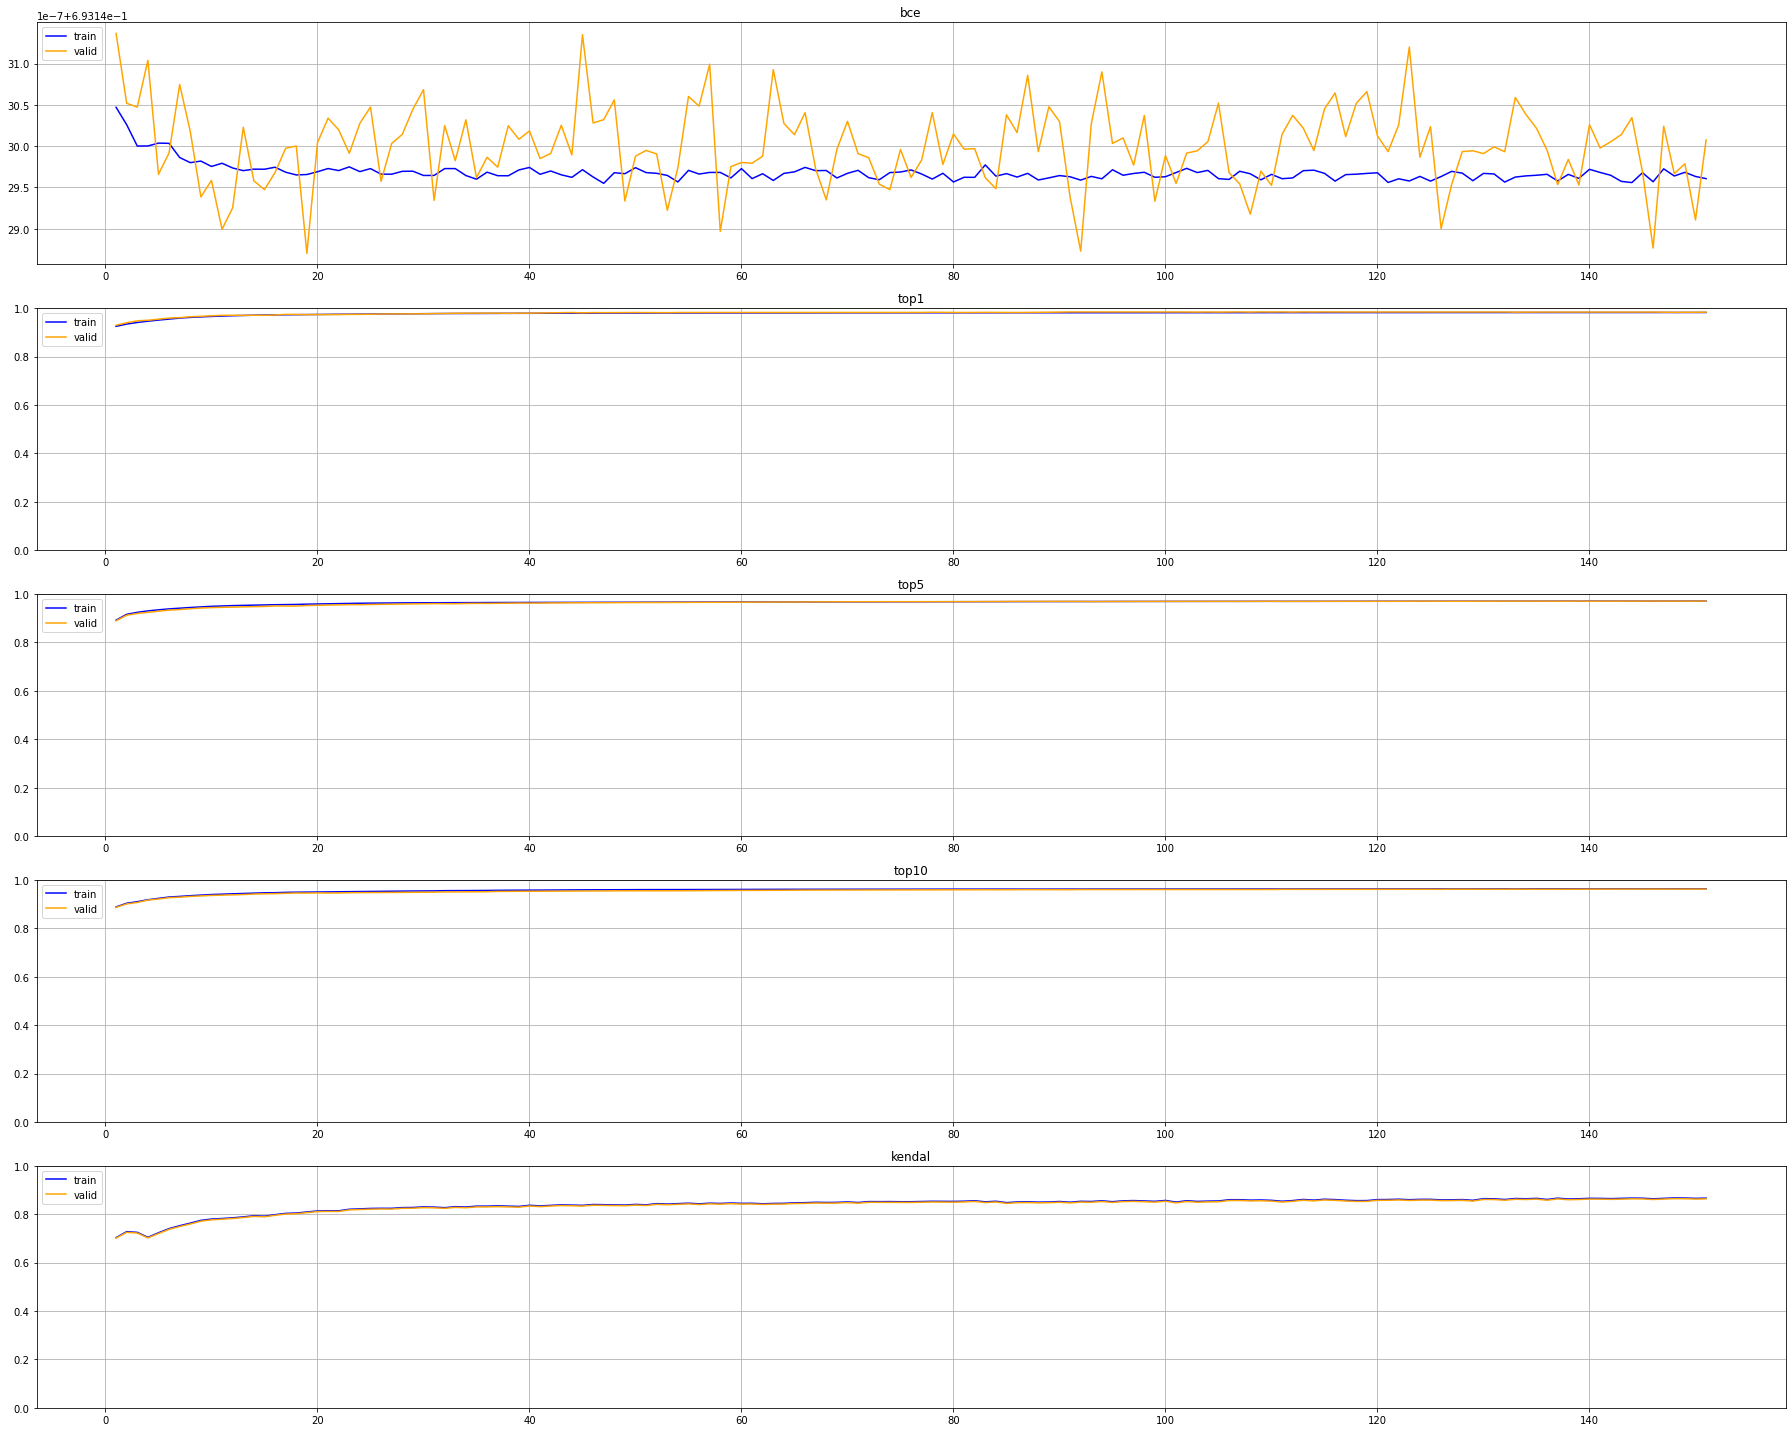

In [38]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    keys = list(train.keys())
    epochs = len(train[keys[0]])

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.plot(x, train[key], color="blue")
        ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
        if key=="bce" or key=="mse":
            pass
        else:
            ax.set_ylim([0, 1])
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Compare diff scale

In [ ]:
weights = os.path.join(setting._root, "weights")

for weight_f in os.listdir(weights):
    print("weight: {}".format(weight_f))
    
    model, _ = load_checkpoint(
                    os.path.join(weights, weight_f),
                    "cpu",
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)
    model.eval()
    
    basename = os.path.splitext(weight_f)[0]
    with open(os.path.join(setting._root, "{}.json".format(basename)), "w") as f:
        jsn = {
            "top1": [],
            "top5": [],
            "top10": [],
            "kendal": [],
            "time": []
        }

        for edge_list, score in zip(synthetic, between):

            data = to_data(edge_list, score)

            start = time.time()
            bc_pr = model(data)
            end = time.time()

            bc_gt = np.array(data.y)


            jsn["time"].append(end-start)
            jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
            jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
            jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
            jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))

        json.dump(jsn, f)
    

In [ ]:
with open(os.path.join(setting._root, "result", "comparison", "200.json"), "r") as f_200, \
    open(os.path.join(setting._root, "result", "comparison", "300.json"), "r") as f_300, \
    open(os.path.join(setting._root, "result", "comparison", "1200.json"), "r") as f_1200, \
    open(os.path.join(setting._root, "result", "comparison", "3000.json"), "r") as f_3000, \
    open(os.path.join(setting._root, "result", "comparison", "5000.json"), "r") as f_5000 :
    
    r_200 = json.load(f_200)
    r_300 = json.load(f_300)
    r_1200 = json.load(f_1200)
    r_3000 = json.load(f_3000)
    r_5000 = json.load(f_5000)

    keys = list(r_200.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([r_200[key], r_300[key], r_1200[key], r_3000[key], r_5000[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        print("\n{}".format(key))
        ### Calculate mean and std
        r_200_ = np.array(r_200[key])
        print("scale=200, mean={}, std={}".format(np.mean(r_200_), np.std(r_200_)))
        
        r_300_ = np.array(r_300[key])
        print("scale=300, mean={}, std={}".format(np.mean(r_300_), np.std(r_300_)))
        
        r_1200_ = np.array(r_1200[key])
        print("scale=1200, mean={}, std={}".format(np.mean(r_1200_), np.std(r_1200_)))
        
        r_3000_ = np.array(r_3000[key])
        print("scale=3000, mean={}, std={}".format(np.mean(r_3000_), np.std(r_3000_)))
         
        r_5000_ = np.array(r_5000[key])
        print("scale=5000, mean={}, std={}".format(np.mean(r_5000_), np.std(r_5000_)))
        
    
    plt.setp(axs,  xticklabels=['200', '300', '1200', "3000", "5000"])
    plt.savefig(os.path.join(setting._root, "result", "comparison", "comp.png"), facecolor="white")
    
    

# Baseline

In [ ]:
G_nx = nx.readwrite.edgelist.read_edgelist(synthetic[0], delimiter="\t")
G_nk = nk.nxadapter.nx2nk(G_nx)
G_pyg = from_networkx(G_nx)

In [ ]:
G_nx

In [ ]:
G_nk

In [ ]:
G_pyg

In [ ]:
G_pyg_ = to_data(synthetic[0], between[0])

In [ ]:
G_pyg_.y

In [ ]:
G_nx_ = G_pyg_

## RK (DIAM)

ApproxBetweenness

Fast approximation of betweenness centrality through sampling.

In [ ]:
ab = nk.centrality.ApproxBetweenness(G_nk, epsilon=0.1)
ab.run()

In [ ]:
ab.scores()

In [ ]:
top_n_percentage(np.array(ab.scores()), G_pyg_.y, k=1)

In [ ]:
kendal_tau_distance(np.array(ab.scores()), G_pyg_.y)

### Synthetic

In [ ]:
with open(os.path.join(setting.root, "rk.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    for edge_list, score in zip(synthetic, between):
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        method = nk.centrality.ApproxBetweenness(G_nk, epsilon=0.1)
        start = time.time()
        method.run()
        end = time.time()
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(method.scores()), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=10))
        
    json.dump(jsn, f)

## ABRA

Approximating betweenness centrality in static and dynamic graphs with rademacher averages

error tolerance λ to 0.01 and the probability δ to 0.1

## KADABRA

In [ ]:
# Initialize algorithm 
kadabra = nk.centrality.KadabraBetweenness(G_nk, 0.05, 0.8) 
kadabra.run() 

In [ ]:
#The 10 most central nodes according to betweenness are then 
kadabra.scores()

In [ ]:
top_n_percentage(np.array(kadabra.scores()), G_pyg_.y, k=500)

### Synthetic

In [ ]:
with open(os.path.join(setting.root, "kadabra.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    for edge_list, score in zip(synthetic, between):
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        method = nk.centrality.KadabraBetweenness(G_nk, 0.05, 0.8)
        start = time.time()
        method.run()
        end = time.time()
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(method.scores()), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=10))
        
    json.dump(jsn, f)

## K-BC (KPATH)

k-centralities: Local approximations of global measures based on shortest paths

For the value of k, we set it to be 20% of the diameter of the network

In [ ]:
def KbcBetweenness(G, k):
    
    if k < 2:
        k = 2.0
        
    inf = float('inf')

    kBC = dict({key:0 for key in G.nodes()})
    for s in G.nodes():
        #Structures
        Q = deque() #Queue
        S = deque() #Stack
        dist = dict({key:inf for key in G.nodes()})
        sig = dict({key:float(0) for key in G.nodes()})
        pred = dict({key:[] for key in G.nodes()})

        #Initialize
        Q.append(s)
        dist[s] = 0
        sig[s] = 1

        #BFS - top-down
        while len(Q) > 0:
            v = Q.popleft()
            if dist[v] > k:
                break;
            S.append(v)
            for w in G[v]:
                if dist[w] == inf:
                    dist[w] = dist[v] + 1
                    if dist[w] <= k:
                        Q.append(w)
                if dist[w] == dist[v] + 1:
                    sig[w] += sig[v]
                    pred[w].append(v)
        #Aggregate - bottom-up
        delta = dict({key:float(0) for key in G.nodes()})
        while len(S) > 0:
            v = S.pop()
            for w in pred[v]:
                delta[w] += (delta[v]+1) * sig[w] / sig[v]
            if v!=s:
                if(G.is_directed()):
                    kBC[v] += delta[v]
                else: kBC[v] += delta[v] / 2.0

    return kBC

In [ ]:
with open(os.path.join(setting.root, "kbc.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    
    for edge_list, score in zip(synthetic, between):
        
        
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        diameter = nx.algorithms.distance_measures.diameter(G_nx)
        start = time.time()
        result = KbcBetweenness(G_nx, diameter * 0.2)
        end = time.time()
        
        result = [v for k, v in sorted(result.items(), key=lambda  item: int(item[0]), reverse=False)]
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(result), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(result), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(result), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(result), G_pyg.y, k=10))
        
    json.dump(jsn, f)

In [ ]:
G_pyg

## DrBC

In [ ]:
with open(os.path.join(setting.root, "drbc.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    model.eval()
    model = model.to("cpu")
    for edge_list, score in zip(synthetic, between):
#         G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
#         G_nk = nk.nxadapter.nx2nk(G_nx)
        data = to_data(edge_list, score)
        
        start = time.time()
        bc_pr = model(data)
        end = time.time()

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
        jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
        jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
        jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))
        
    json.dump(jsn, f)

## Node2Vec

# Youtube

In [ ]:
yt_nx = utils.to_networkx(yt_data, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)

In [ ]:
yt_nx

In [ ]:
from_networkx(yt_nx)

In [ ]:
with open(os.path.join(setting.root, "youtube.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    
    yt_pyg = to_data(yt[0], yt_score[0], y_sep=r":")
    yt_nx = utils.to_networkx(yt_pyg, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)
    yt_nk = nk.nxadapter.nx2nk(yt_nx)
    
    
    ### RK
    method = nk.centrality.ApproxBetweenness(yt_nk, epsilon=0.1)
    start = time.time()
    method.run()
    end = time.time()
    
    print("\nRK")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(np.array(method.scores()), yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=10)))
    
    
    ### Kadabra
    method = nk.centrality.KadabraBetweenness(yt_nk, 0.05, 0.8)
    start = time.time()
    method.run()
    end = time.time()
    
    print("\nKadabra")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(np.array(method.scores()), yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=10)))
    
    
    model.eval()
    start = time.time()
    bc_pr = model(yt_pyg)
    end = time.time()

    print("\nDrBC")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(bc_pr, yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=10)))

        
#     json.dump(jsn, f)

In [ ]:
bc_pr.size()

# Visualize all result

In [ ]:
with open(os.path.join(setting.root, "kbc.json"), "r") as kbc_f, \
    open(os.path.join(setting.root, "kadabra.json"), "r") as kadabra_f, \
    open(os.path.join(setting.root, "rk.json"), "r") as rk_f, \
    open(os.path.join(setting.root, "drbc.json"), "r") as drbc_f:
    
    kbc = json.load(kbc_f)
    kadabra = json.load(kadabra_f)
    rk = json.load(rk_f)
    drbc = json.load(drbc_f)

    keys = list(kbc.keys())

    x = np.linspace(1, 30, 30)

    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        ax.plot(x, rk[key], "o")
        ax.plot(x, kbc[key], "o")
        ax.plot(x, kadabra[key], "o")
        ax.plot(x, drbc[key], "o")
        ax.legend(["rk", "kbc", "kadabra", "drbc"], loc='center right', bbox_to_anchor=(1, 0.5))

        ax.set_xticks(x)
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(os.path.join(setting.root, "synthetic_each.png"), facecolor="white")

In [ ]:
with open(os.path.join(setting.root, "kbc.json"), "r") as kbc_f, \
    open(os.path.join(setting.root, "kadabra.json"), "r") as kadabra_f, \
    open(os.path.join(setting.root, "rk.json"), "r") as rk_f, \
    open(os.path.join(setting.root, "drbc.json"), "r") as drbc_f:
    
    kbc = json.load(kbc_f)
    kadabra = json.load(kadabra_f)
    rk = json.load(rk_f)
    drbc = json.load(drbc_f)

    keys = list(kbc.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([rk[key], kbc[key], kadabra[key], drbc[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        ### Calculate mean and std
        print("\n{}".format(key))
        rk_ = np.array(rk[key])
        print("RK: mean={}, std={}".format(np.mean(rk_), np.std(rk_)))
        
        kbc_ = np.array(kbc[key])
        print("KBC: mean={}, std={}".format(np.mean(kbc_), np.std(kbc_)))
        
        kadabra_ = np.array(kadabra[key])
        print("KADABRA: mean={}, std={}".format(np.mean(kadabra_), np.std(kadabra_)))
        
        drbc_ = np.array(drbc[key])
        print("DrBC: mean={}, std={}".format(np.mean(drbc_), np.std(drbc_)))
        
    
    plt.setp(axs,  xticklabels=['rk', 'kbc', 'kadabra', "drbc"])
    plt.savefig(os.path.join(setting.root, "synthetic_box.png"), facecolor="white")
    
    